Using device: mps


Device set to use cpu


  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: Expected parameter logits (Tensor of shape (1, 50, 50257)) of distribution Categorical(logits: torch.Size([1, 50, 50257])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], device='mps:0',
       grad_fn=<SubBackward0>)

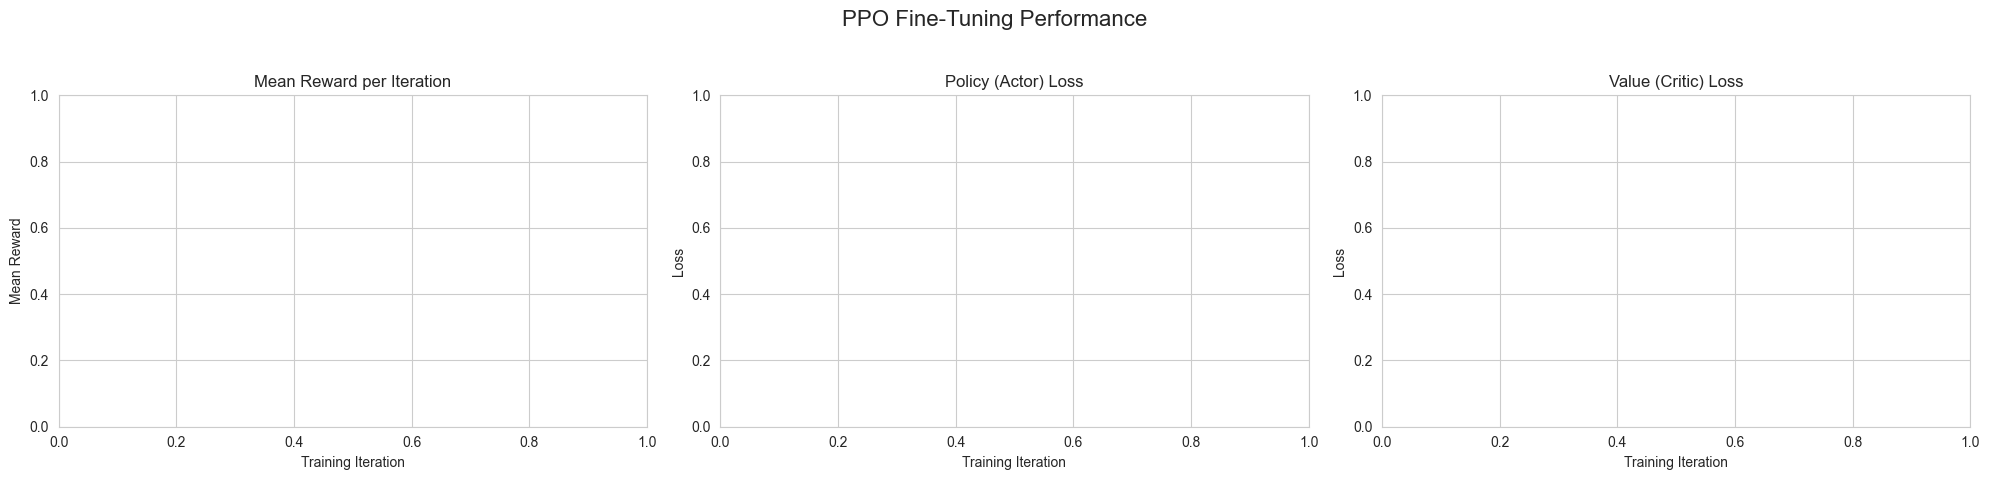

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.distributions import Categorical

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Set up seaborn for plotting
sns.set_style("whitegrid")

# --- 1. Configuration ---
# Use a class to hold all hyperparameters and settings for easy access and modification.
class PPOConfig:
    def __init__(self):
        # Determine device
        if torch.cuda.is_available():
            self.device = "cuda"
        # Check for Apple Silicon MPS support
        elif torch.backends.mps.is_available():
            self.device = "mps"
        else:
            self.device = "cpu"
        print(f"Using device: {self.device}")

        # LLM and Tokenizer configuration
        self.model_name = "distilgpt2"
        self.max_gen_len = 50  # Max length of generated responses

        # PPO hyperparameters
        self.learning_rate_actor = 1e-5
        self.learning_rate_critic = 1e-4
        self.gamma = 0.99  # Discount factor for future rewards
        self.lam = 0.95    # Lambda for Generalized Advantage Estimation (GAE)
        self.clip_epsilon = 0.2  # Clipping parameter for PPO
        self.ppo_epochs = 4      # Number of optimization epochs per batch
        self.batch_size = 32     # Number of prompts to process in a batch

        # Training settings
        self.training_iterations = 50 # Total number of training iterations

# Instantiate configuration
config = PPOConfig()

# --- 2. Model and Tokenizer Initialization ---
# We need four models: Actor, Critic, a frozen reference model for KL penalty,
# and a simulated reward model.

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
# Set a padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Actor Model (the one we fine-tune)
actor_model = AutoModelForCausalLM.from_pretrained(config.model_name).to(config.device)

# Reference Model (frozen copy of the original policy)
# This is used to calculate the KL divergence penalty to prevent the actor
# from straying too far from the original language model.
ref_model = AutoModelForCausalLM.from_pretrained(config.model_name).to(config.device)
# Freeze all parameters of the reference model
for param in ref_model.parameters():
    param.requires_grad = False

# Critic Model
# The critic is a separate model with a value head. It takes a state (sequence of tokens)
# and outputs a single scalar value representing the expected future reward.
class Critic(nn.Module):
    def __init__(self, model_name):
        super(Critic, self).__init__()
        # Load the base transformer model
        self.transformer = AutoModelForCausalLM.from_pretrained(model_name)
        # Add a custom linear layer (value head) on top of the transformer's output
        # The input dimension is the hidden size of the transformer model
        self.value_head = nn.Linear(self.transformer.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None):
        # Get the hidden states from the transformer model
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        # We use the last hidden state of the sequence
        last_hidden_state = outputs.hidden_states[-1]
        # Get the value prediction from the value head
        # We'll use the hidden state of the last token to predict the value
        value = self.value_head(last_hidden_state).squeeze(-1)
        return value

critic_model = Critic(config.model_name).to(config.device)

# Optimizers for Actor and Critic
actor_optimizer = Adam(actor_model.parameters(), lr=config.learning_rate_actor)
critic_optimizer = Adam(critic_model.parameters(), lr=config.learning_rate_critic)

# --- 3. Simulated Reward Model ---
# In a real RLHF setup, this would be a complex model trained on human preferences.
# For this example, we simulate it with a sentiment analysis pipeline.
# The goal is to make the LLM generate positive-sounding text.
sentiment_model_name = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=sentiment_model_name,
    device=config.device if config.device != 'mps' else -1 # MPS doesn't work well with pipelines
)

def get_rewards(texts):
    """
    Calculates a reward for each text based on its predicted sentiment.
    The reward is higher for "POSITIVE" sentiment.
    """
    rewards = []
    for text in texts:
        try:
            # Using truncation and max_length to handle potentially long inputs
            result = sentiment_pipeline(text, truncation=True, max_length=512)[0]
            if result['label'] == 'POSITIVE':
                rewards.append(torch.tensor(result['score'], device=config.device))
            else:
                # Penalize negative sentiment by giving a negative reward
                rewards.append(torch.tensor(-result['score'], device=config.device))
        except Exception as e:
            # Handle potential errors with long texts or other pipeline issues
            print(f"Error processing text for reward: {e}")
            rewards.append(torch.tensor(0.0, device=config.device)) # Neutral reward on error
    return rewards


# --- 4. PPO Core Logic ---

def generate_experience(prompts):
    """
    Generates a batch of experiences by having the actor model respond to prompts.
    """
    actor_model.eval()
    critic_model.eval()

    # Data lists to store experience tuples
    prompts_t, responses_t, log_probs_t, values_t, rewards_t, kl_divs_t = [], [], [], [], [], []
    attention_masks_t = []

    for prompt in prompts:
        # Encode the prompt, now getting both input_ids and attention_mask
        encoding = tokenizer(prompt, return_tensors="pt")
        input_ids = encoding["input_ids"].to(config.device)
        attention_mask = encoding["attention_mask"].to(config.device)

        # Generate a response from the actor model
        # Pass the attention_mask to the generate function
        generated_output = actor_model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=config.max_gen_len + input_ids.shape[1],
            do_sample=True,
            top_k=50,
            top_p=0.95,
            pad_token_id=tokenizer.pad_token_id
        )

        # The generated sequence includes the prompt, so we slice it
        response_ids = generated_output[:, input_ids.shape[1]:]
        full_ids = torch.cat([input_ids, response_ids], dim=1)
        
        # Create the full attention mask corresponding to the full sequence
        response_attention_mask = torch.ones_like(response_ids)
        full_attention_mask = torch.cat([attention_mask, response_attention_mask], dim=1)

        # Decode for reward calculation and storage
        response_text = tokenizer.decode(response_ids[0], skip_special_tokens=True)
        
        # --- Calculate necessary values for PPO ---
        with torch.no_grad():
            # Pass attention mask to all model calls
            logits = actor_model(full_ids, attention_mask=full_attention_mask).logits
            log_prob = Categorical(logits=logits[:, -response_ids.shape[1]-1:-1, :]).log_prob(response_ids)

            value = critic_model(full_ids, attention_mask=full_attention_mask).detach()[:, -1]

            ref_logits = ref_model(full_ids, attention_mask=full_attention_mask).logits
            kl_div = (torch.nn.functional.kl_div(
                torch.nn.functional.log_softmax(logits, dim=-1),
                torch.nn.functional.log_softmax(ref_logits, dim=-1),
                log_target=True,
                reduction='none'
            )).sum(-1).mean()

        # Store the experience
        prompts_t.append(input_ids)
        responses_t.append(response_ids)
        attention_masks_t.append(full_attention_mask)
        log_probs_t.append(log_prob.sum())
        values_t.append(value)
        
        reward_tensor = get_rewards([response_text])[0]
        rewards_t.append(reward_tensor)
        kl_divs_t.append(kl_div)
        
    actor_model.train()
    critic_model.train()

    return prompts_t, responses_t, attention_masks_t, log_probs_t, values_t, rewards_t, kl_divs_t


def ppo_update(prompts, responses, attention_masks, old_log_probs, returns, advantages):
    """
    Performs a single PPO update step for both actor and critic.
    """
    for _ in range(config.ppo_epochs):
        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()

        policy_losses = []
        value_losses = []

        # Iterate over the batch of experiences
        for i in range(len(prompts)):
            prompt_ids = prompts[i]
            response_ids = responses[i]
            full_ids = torch.cat([prompt_ids, response_ids], dim=1)
            full_attention_mask = attention_masks[i]

            # Pass attention mask to all model calls
            logits = actor_model(full_ids, attention_mask=full_attention_mask).logits
            new_log_prob = Categorical(logits=logits[:, -response_ids.shape[1]-1:-1, :]).log_prob(response_ids).sum()
            new_value = critic_model(full_ids, attention_mask=full_attention_mask)[:, -1]

            # --- 1. Calculate Policy Loss (Actor) ---
            ratio = torch.exp(new_log_prob - old_log_probs[i])
            surrogate1 = ratio * advantages[i]
            surrogate2 = torch.clamp(ratio, 1 - config.clip_epsilon, 1 + config.clip_epsilon) * advantages[i]
            policy_loss = -torch.min(surrogate1, surrogate2)
            policy_losses.append(policy_loss)

            # --- 2. Calculate Value Loss (Critic) ---
            value_loss = (new_value - returns[i]) ** 2
            value_losses.append(value_loss)

        # Average losses over the batch
        total_policy_loss = torch.stack(policy_losses).mean()
        total_value_loss = torch.stack(value_losses).mean()
        
        # Combine losses and backpropagate
        total_loss = total_policy_loss + 0.5 * total_value_loss
        total_loss.backward()

        # FIX 3: Add gradient clipping to prevent exploding gradients which cause 'nan' values.
        torch.nn.utils.clip_grad_norm_(actor_model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(critic_model.parameters(), 1.0)

        # Step the optimizers
        actor_optimizer.step()
        critic_optimizer.step()

    return total_policy_loss.item(), total_value_loss.item()


def compute_advantages_and_returns(rewards, values):
    """
    Computes advantages and returns using Generalized Advantage Estimation (GAE).
    """
    detached_values = [v.detach() for v in values] + [torch.tensor([0.0], device=config.device)]
    
    returns = []
    advantages = []
    gae = 0
    
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + config.gamma * detached_values[i+1] - detached_values[i]
        gae = delta + config.gamma * config.lam * gae
        advantages.insert(0, gae)
        returns.insert(0, gae + detached_values[i])
        
    return returns, advantages


# --- 5. Visualization Setup ---

def setup_plots():
    """Initializes the plot for live updating."""
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle("PPO Fine-Tuning Performance", fontsize=16)
    
    axes[0].set_title("Mean Reward per Iteration")
    axes[0].set_xlabel("Training Iteration")
    axes[0].set_ylabel("Mean Reward")
    
    axes[1].set_title("Policy (Actor) Loss")
    axes[1].set_xlabel("Training Iteration")
    axes[1].set_ylabel("Loss")

    axes[2].set_title("Value (Critic) Loss")
    axes[2].set_xlabel("Training Iteration")
    axes[2].set_ylabel("Loss")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, axes

def update_plots(fig, axes, metrics_df):
    """Updates the plots with new data."""
    for ax in axes:
        ax.clear()

    sns.lineplot(x='iteration', y='mean_reward', data=metrics_df, ax=axes[0], marker='o')
    axes[0].set_title("Mean Reward per Iteration")
    
    sns.lineplot(x='iteration', y='policy_loss', data=metrics_df, ax=axes[1], marker='o', color='r')
    axes[1].set_title("Policy (Actor) Loss")

    sns.lineplot(x='iteration', y='value_loss', data=metrics_df, ax=axes[2], marker='o', color='g')
    axes[2].set_title("Value (Critic) Loss")

    fig.canvas.draw()
    plt.pause(0.1)


# --- 6. Main Training Loop ---

if __name__ == "__main__":
    prompts = [
        "The movie was",
        "This new technology is",
        "I think this product is",
        "The food at the restaurant was",
        "Her performance in the play was",
        "The book I just read was",
        "My vacation was",
        "The customer service I received was"
    ]
    
    metrics = {
        'iteration': [],
        'mean_reward': [],
        'mean_kl_div': [],
        'policy_loss': [],
        'value_loss': []
    }

    plt.ion()
    fig, axes = setup_plots()
    
    pbar = tqdm(range(config.training_iterations))
    for iteration in pbar:
        exp_prompts, exp_responses, exp_attention_masks, exp_log_probs, exp_values, exp_rewards, exp_kl_divs = generate_experience(prompts * (config.batch_size // len(prompts)))
        
        returns, advantages = compute_advantages_and_returns(exp_rewards, exp_values)
        
        policy_loss, value_loss = ppo_update(exp_prompts, exp_responses, exp_attention_masks, exp_log_probs, returns, advantages)
        
        mean_reward = torch.stack(exp_rewards).mean().item()
        mean_kl = torch.stack(exp_kl_divs).mean().item()
        
        metrics['iteration'].append(iteration)
        metrics['mean_reward'].append(mean_reward)
        metrics['mean_kl_div'].append(mean_kl)
        metrics['policy_loss'].append(policy_loss)
        metrics['value_loss'].append(value_loss)
        
        pbar.set_description(
            f"Reward: {mean_reward:.2f} | KL Div: {mean_kl:.2f} | P_Loss: {policy_loss:.2f} | V_Loss: {value_loss:.2f}"
        )
        
        metrics_df = pd.DataFrame(metrics)
        update_plots(fig, axes, metrics_df)

    # --- 7. Final Results ---
    plt.ioff()
    plt.show()

    print("\n--- Generating final examples after fine-tuning ---")
    actor_model.eval()
    for prompt in prompts[:3]:
        # Pass attention mask during final generation
        encoding = tokenizer(prompt, return_tensors="pt")
        input_ids = encoding["input_ids"].to(config.device)
        attention_mask = encoding["attention_mask"].to(config.device)
        
        output = actor_model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=config.max_gen_len + input_ids.shape[1],
            do_sample=True,
            top_k=50,
            pad_token_id=tokenizer.pad_token_id
        )
        full_text = tokenizer.decode(output[0], skip_special_tokens=True)
        print(f"Prompt: {prompt}")
        print(f"Generated: {full_text}\n")


In [11]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# 1. Load the pre-trained model and tokenizer
# We'll use DistilGPT-2, a smaller and faster version of GPT-2
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# 2. Prepare your input prompt
prompt = "The best thing about learning to code is"

# 3. Tokenize the input prompt
# The tokenizer converts the text into a format the model can understand (a sequence of numbers)
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# 4. Generate text
# The model will predict the next words in the sequence
# We'll generate a sequence of a maximum of 50 tokens
output_sequences = model.generate(
    input_ids,
    max_length=500,
    num_return_sequences=1,
    no_repeat_ngram_size=2, # Helps to avoid repetitive phrases
    early_stopping=True
)

# 5. Decode the generated sequence back to text
generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)

# 6. Print the results
print("Prompt:", prompt)
print("input_ids", input_ids)
print("output_sequences", output_sequences)
print("Generated Text:", generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: The best thing about learning to code is
input_ids tensor([[ 464, 1266, 1517,  546, 4673,  284, 2438,  318]])
output_sequences tensor([[  464,  1266,  1517,   546,  4673,   284,  2438,   318,   326,   345,
           460,  2193,   284,  3551,  2438,   287,   257,   835,   326,   318,
          2562,   284,  1833,    13,   198,   198,   464,   717,  1517,   345,
           761,   284,   466,   318,   284,  2193,   703,   284,   779,   262,
          3303,    13,   921,   460,   470,   655,  2193,   262, 19165,   286,
           262,  8300,  3303,    11,   345,   423,   284,   760,   703,   262,
          2438,  2499,    13,   383,  3303,   318,   257,  1049,   835,   284,
           651,  2067,    13,   632,   338,   257,  1256,  4577,   284,  1100,
           290,  1833,   621,   262,   584,  8950,    13,   314,  1053,  3194,
           257,  1178,  6685,   319,   428,  7243,    11,   475,   314,  1101,
           407,  1016,   284,   467,   656,   340,   994,    13,  5455,    